In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/hyper-kvasir-segmented-images.zip

Archive:  /content/drive/MyDrive/hyper-kvasir-segmented-images.zip
replace segmented-images/bounding-boxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: segmented-images/bounding-boxes.json  
replace segmented-images/masks/cju88oh0po9gq0801nge4tgr1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace segmented-images/masks/cju88oh0po9gq0801nge4tgr1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: segmented-images/masks/cju88oh0po9gq0801nge4tgr1.jpg  
  inflating: segmented-images/masks/cju34uhepd3dd0799hs8782ad.jpg  
  inflating: segmented-images/masks/cju8bgdmqrksy0801tozdmraa.jpg  
  inflating: segmented-images/masks/cju5ddda9bkkt0850enzwatb1.jpg  
  inflating: segmented-images/masks/cju0s690hkp960855tjuaqvv0.jpg  
  inflating: segmented-images/masks/cju5nyu31gv8e0871zpk74a2n.jpg  
  inflating: segmented-images/masks/cju358pwtdby20878cg7nm0np.jpg  
  inflating: segmented-images/masks/cju5cu8qkb84x08186jwo8yin.jpg  
  inflating: segme

In [28]:

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold,cross_val_score,cross_validate
from sklearn.metrics import make_scorer

In [29]:

print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.10.0-dev20220612


In [30]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "./segmented-images/"

In [31]:
def load_data(path, split=0.18):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y),(valid_x,valid_y)  ,(test_x, test_y)

In [32]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [33]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [34]:
(train_x, train_y),(valid_x,valid_y) ,(test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  640
Validation data:  180
Testing data:  180


In [35]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

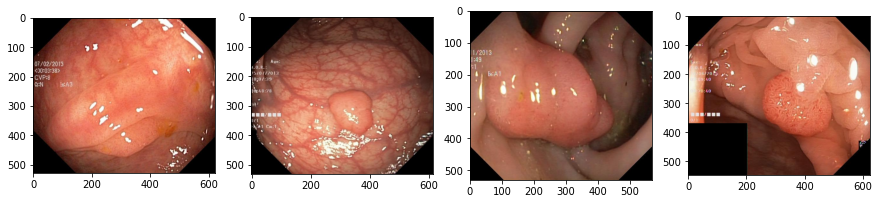

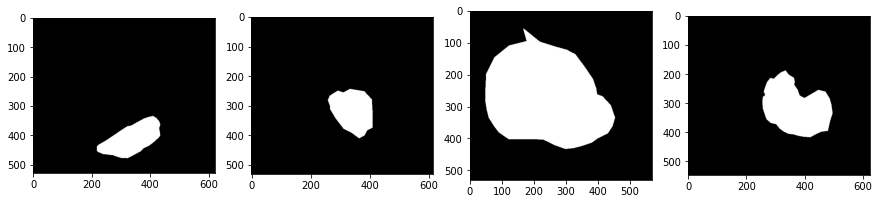

In [36]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [37]:
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs,skip,num_filters):
    x = Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
    x = Concatenate()([x,skip])
    x = conv_block(x,num_filters)
    return x

In [38]:
def build_effuent(input_shape):
    inputs = keras.Input(input_shape,name="input_image")
    encoder = keras.applications.efficientnet.EfficientNetB0(include_top=False,weights="imagenet",input_tensor=inputs)
#     encoder.summary()
    
    #First skip connection
    s1 = encoder.get_layer("input_image").output  #256
    s2 = encoder.get_layer("block2a_expand_activation").output #128
    s3 = encoder.get_layer("block3a_expand_activation").output #64
    s4 = encoder.get_layer("block4a_expand_activation").output #32
    
    #Bottleneck
    b1 =encoder.get_layer("block6a_expand_activation").output #16     
    #decoder
    d1 = decoder_block(b1,s4,512)   #32
#     print(d1.shape)
    d2 = decoder_block(d1,s3,256)   #64
    d3 = decoder_block(d2,s2,128)   #128
    d4 = decoder_block(d3,s1,64)   #256
#     print(d4.shape)

#Output

    outputs = Conv2D(1,1,padding="same",activation="sigmoid")(d4)
    print(outputs.shape)
    
    model = Model(inputs,outputs,name="EfficientNetB0_UNET")
    return model

In [39]:
model = build_effuent((IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

(None, 256, 256, 1)
Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_image[0][0]']            
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0      

 block2a_project_conv (Conv2D)  (None, 64, 64, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 64, 64, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 64, 64, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 64, 64, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 32, 32, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 32, 32, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 32, 32, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 32, 32, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 16, 16, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 16, 16, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 16, 16, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 16, 16, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

                                                                                                  
 batch_normalization_5 (BatchNo  (None, 128, 128, 12  512        ['conv2d_5[0][0]']               
 rmalization)                   8)                                                                
                                                                                                  
 activation_5 (Activation)      (None, 128, 128, 12  0           ['batch_normalization_5[0][0]']  
                                8)                                                                
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 64  32832      ['activation_5[0][0]']           
 spose)                         )                                                                 
                                                                                                  
 concatena

In [40]:

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [41]:
def IoU(y_true,y_pred):
  y_pred = tf.keras.layers.Flatten()(y_pred)
  y_true = tf.keras.layers.Flatten()(y_true)
  intersection = tf.reduce_sum(y_true*y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
  return intersection/union


In [43]:

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [44]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef,IoU, Recall(), Precision(),]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [45]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [46]:
i = []
m = []

for images,masks in train_dataset.take(int(len(train_x)/8)):
  i.append(images)
  m.append(masks)

In [47]:
i = np.array(i)
m = np.array(m)
i=i.reshape(-1,256,256,3)
m = m.reshape(-1,256,256,1)
print(i.shape)
print(m.shape)

(640, 256, 256, 3)
(640, 256, 256, 1)


In [ ]:
# !pip install scikeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from scikeras.wrappers import KerasClassifier
# clf = KerasClassifier(model, epochs=25, batch_size=8, verbose=0)


In [ ]:
# scorer ={"dice_coef":make_scorer(dice_coef,greater_is_better=True),
#          "dice_loss":make_scorer(dice_loss,greater_is_better=False)}
         
# kfold = KFold(10)

# accuracy  =cross_validate(clf,i,m,cv=kfold,scoring=scorer)

INFO:tensorflow:Assets written to: ram:///tmp/tmp5509etk3/assets


ValueError: ignored

In [48]:
def train_kfold():

		print("loading data")

		image_indices = np.arange(0,i.shape[0] , 1)

		n_splits=10
		kfold = KFold(n_splits = n_splits, shuffle=True)
		cvscores = []

		for train_index, test_index in kfold.split(image_indices):
			print("TRAIN:", train_index, "TEST:", test_index)

			## Below steps are necessary to generate reproducible model runs
			# Necessary for starting Numpy generated random numbers in a well-defined initial state.
			np.random.seed(42)

	

			


			print("loading data done")

			

			print('Fitting model...')
			model.fit(i[train_index], m[train_index], batch_size=8, epochs=5, verbose=1,validation_split=0.2, shuffle=True, callbacks=callbacks)

			print('evaluate test data')
			score = model.evaluate(x = i[test_index], y= m[test_index])
			print('Test loss:', score[0])
			print('Test accuracy:', score[1])
			cvscores.append(score[1] * 100)

		print('Mean score with std deviation over {0} folds'.format(n_splits))
		print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


In [ ]:
train_kfold()

loading data
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  16  17  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  80  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 106 107 108 109 110 112 113 114 115 116 117 118
 120 122 123 125 126 127 128 129 130 131 132 133 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 177 181 182
 183 184 185 186 187 188 189 190 191 192 193 195 196 197 199 200 201 202
 204 205 206 210 211 212 213 214 215 216 217 218 219 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 242 243 244
 245 246 247 248 249 251 252 253 254 255 256 257 258 259 260 261 262 263
 265 266 267 268 269 270 271 27

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
80/80 [==============================] - 82s 496ms/step - loss: 0.4273 - dice_coef: 0.5727 - IoU: 0.4148 - recall: 0.7519 - precision: 0.5328 - val_loss: 0.7576 - val_dice_coef: 0.2409 - val_IoU: 0.1382 - val_recall: 0.1489 - val_precision: 0.3528 - lr: 1.0000e-04
Epoch 2/30
80/80 [==============================] - 36s 455ms/step - loss: 0.2540 - dice_coef: 0.7460 - IoU: 0.5987 - recall: 0.7907 - precision: 0.8079 - val_loss: 0.8968 - val_dice_coef: 0.1029 - val_IoU: 0.0543 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/30
80/80 [==============================] - 36s 453ms/step - loss: 0.2066 - dice_coef: 0.7934 - IoU: 0.6610 - recall: 0.8122 - precision: 0.8598 - val_loss: 0.6885 - val_dice_coef: 0.3093 - val_IoU: 0.1860 - val_recall: 0.5858 - val_precision: 0.2287 - lr: 1.0000e-04
Epoch 4/30
80/80 [==============================] - 36s 454ms/step - loss: 0.1696 - dice_coef: 0.8304 - IoU: 0.7132 - recall: 0.8369 - precision: 0.8938 - val_loss:

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps=  len(test_x)//BATCH
if len(test_x)// BATCH !=0:
  test_steps+=1


model.evaluate(test_dataset,steps=test_steps)


23/23 [==============================] - 3s 113ms/step - loss: 0.1669 - dice_coef: 0.8319 - IoU: 0.7161 - recall: 0.7965 - precision: 0.8801


[0.16692107915878296,
 0.8319156765937805,
 0.7161372900009155,
 0.7964674830436707,
 0.8801242113113403]

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

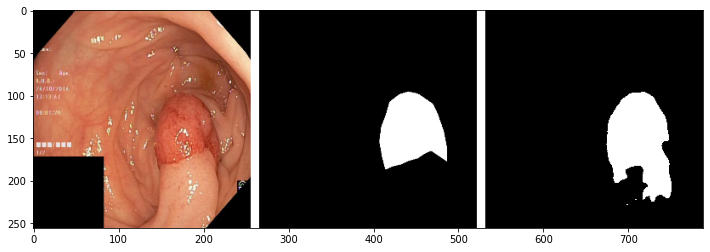

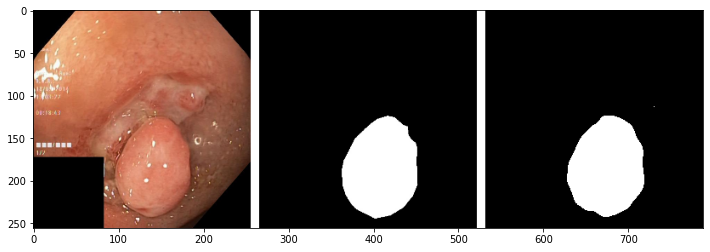

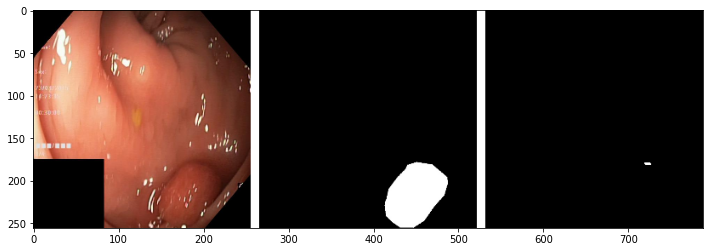

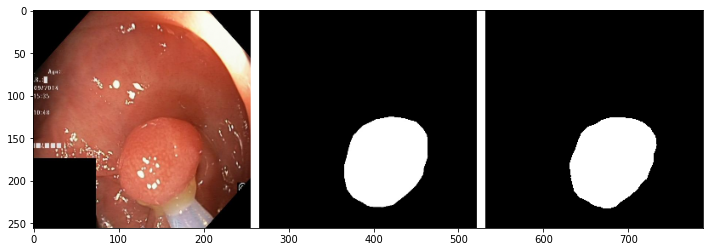

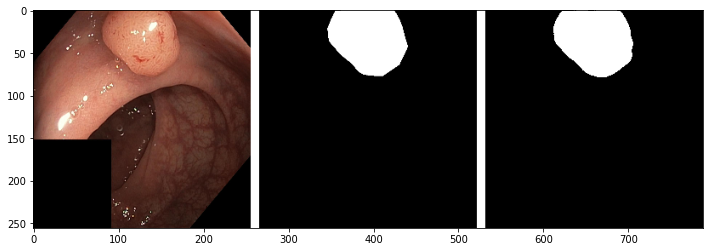

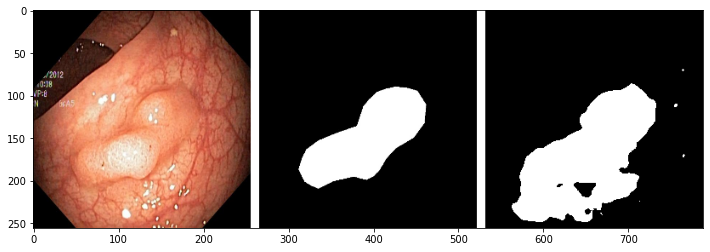

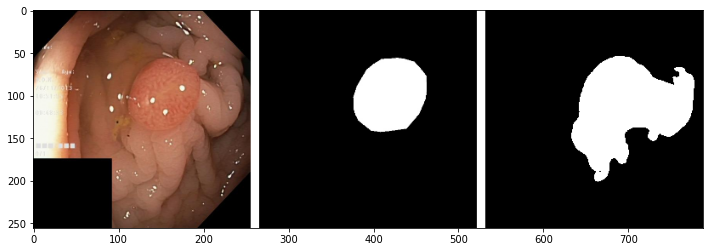

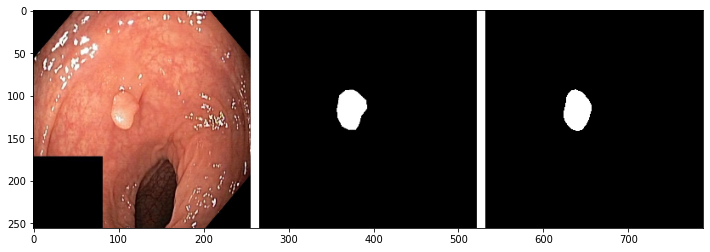

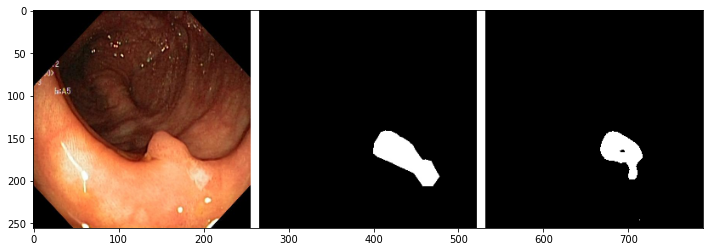

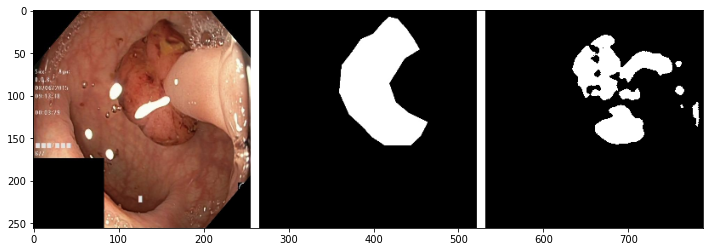

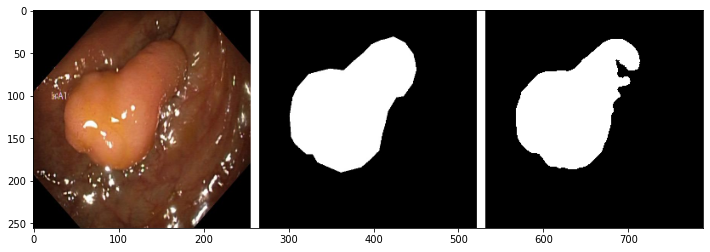

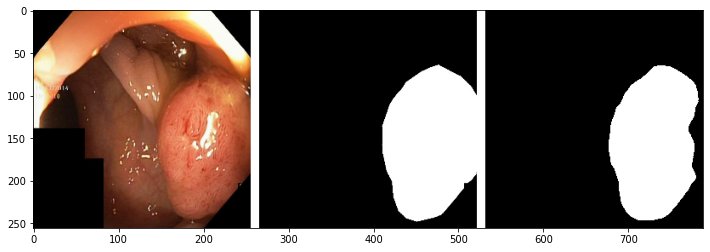

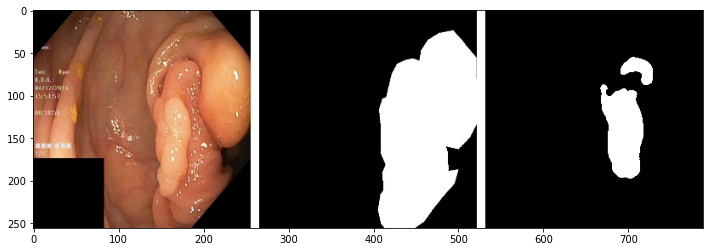

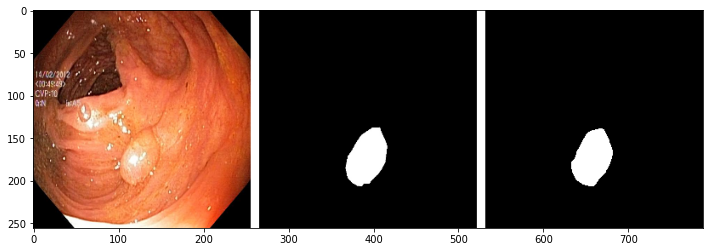

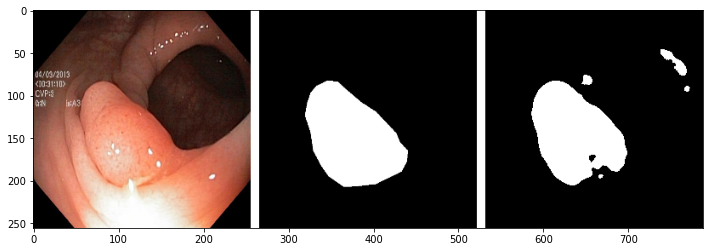

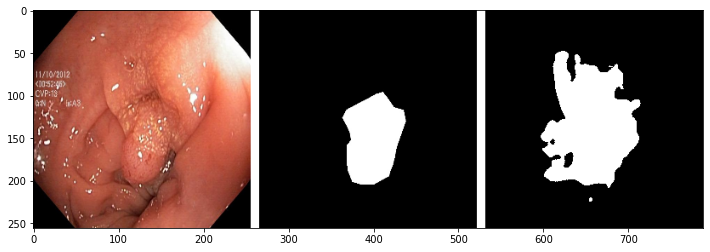

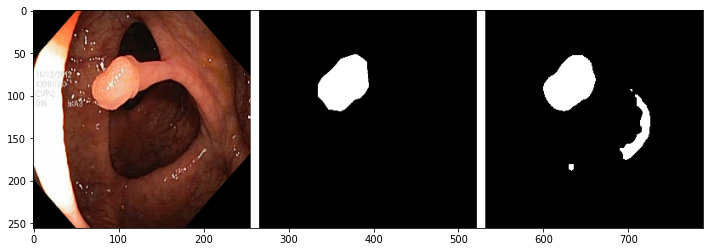

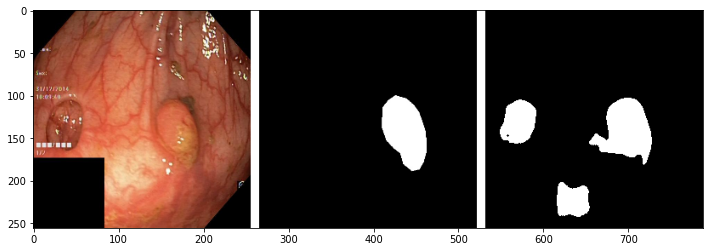

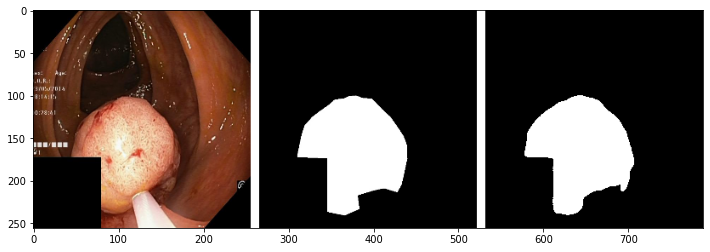

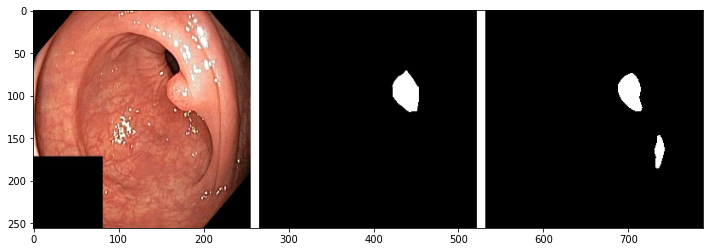

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:20], test_y[:20])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)